### Data Preparation 

In [1]:
import sys
sys.path.append('../')
import pickle
from preprocessing.imdb_datareader import IMDBDataReader
from preprocessing.factorization_machine_transformer import  FactorizationMachineTransformer

user_item  = pickle.load(open('data/user_item.p', 'rb')) 
users = {}
items = {}
train_user_item = user_item[:int(len(user_item)*0.8)]
test_user_item = user_item[int(len(user_item)*0.8):]
transformer = FactorizationMachineTransformer(users, items, train_user_item)
X_train, Y_train, _, _, nFeatures = transformer.get_feature_vectors(users, items, train_user_item)
X_test, Y_test,X_cold_test, Y_cold_test, nFeatures = transformer.get_feature_vectors(users, items, test_user_item)

In [2]:
X_test.shape

(2863, 2367)

#### Upload Data to S3 

In [ ]:
# create s3 bucket for later use 
!aws s3api create-bucket --bucket recommendation-demo-yianc-0814 --region us-west-2 --create-bucket-configuration LocationConstraint=us-west-2

In [3]:

bucket = 'recommendation-demo-yianc'
prefix = 'sagemaker/fm-movielens-ui'
train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train')
output_prefix  = 's3://{}/{}/output'.format(bucket, prefix)


import io,boto3
import sagemaker.amazon.common as smac


def writeDatasetToProtobuf(X, bucket, prefix, key, d_type, Y=None):
    '''transform the sparse matrix to sparse tensor in protobuf format'''
    buf = io.BytesIO()
    if d_type == "sparse":
        smac.write_spmatrix_to_sparse_tensor(buf, X, labels=Y)
    else:
        smac.write_numpy_to_dense_tensor(buf, X, labels=Y)
        
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
 
    
train_data = writeDatasetToProtobuf(X_train, bucket, train_prefix, train_key, "sparse", Y_train)    
  


In [4]:
print('Output: {}'.format(output_prefix))
print('Train data: {}'.format(train_data))

Output: s3://recommendation-demo-yianc/sagemaker/fm-movielens-ui/output
Train data: s3://recommendation-demo-yianc/sagemaker/fm-movielens-ui/train/train.protobuf


In [5]:
import boto3 
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

region = boto3.Session().region_name
container = get_image_uri(region, 'factorization-machines', 'latest')
crole = get_execution_role() 
print('region:{}, container:{}, role:{}'.format(region, container, crole)) 


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


region:us-east-1, container:382416733822.dkr.ecr.us-east-1.amazonaws.com/factorization-machines:latest, role:arn:aws:iam::230755935769:role/myfirstrole


In [6]:
import sagemaker

# use sagemaker api to conduct factorization machine training 
fm = sagemaker.estimator.Estimator(container,
                                   crole, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_prefix,
                                   sagemaker_session=sagemaker.Session())



fm.set_hyperparameters(
                      feature_dim=nFeatures,
                      predictor_type='binary_classifier',
#                       predictor_type='regressor',
                      mini_batch_size=200,
                      num_factors=64,
                      epochs=50)

fm.fit({'train': train_data})


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-20 08:12:13 Starting - Starting the training job...
2020-08-20 08:12:15 Starting - Launching requested ML instances......
2020-08-20 08:13:27 Starting - Preparing the instances for training......
2020-08-20 08:14:35 Downloading - Downloading input data...
2020-08-20 08:15:13 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[08/20/2020 08:15:15 INFO 140609059526464] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'

[2020-08-20 08:15:22.168] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 10, "duration": 1124, "num_examples": 400, "num_bytes": 5120000}
[08/20/2020 08:15:22 INFO 140609059526464] #quality_metric: host=algo-1, epoch=4, train binary_classification_accuracy <score>=0.634175
[08/20/2020 08:15:22 INFO 140609059526464] #quality_metric: host=algo-1, epoch=4, train binary_classification_cross_entropy <loss>=0.64820052557
[08/20/2020 08:15:22 INFO 140609059526464] #quality_metric: host=algo-1, epoch=4, train binary_f_1.000 <score>=0.720156817747
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1127.012014389038, "sum": 1127.012014389038, "min": 1127.012014389038}}, "EndTime": 1597911322.169535, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1597911321.042105}

[08/20/2020 08:15:22 INFO 140609059526464] #progress_metric: host=algo-1, completed 10 % of epochs
#metrics {"Metrics": {"Max 

[2020-08-20 08:15:32.340] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 28, "duration": 1159, "num_examples": 400, "num_bytes": 5120000}
[08/20/2020 08:15:32 INFO 140609059526464] #quality_metric: host=algo-1, epoch=13, train binary_classification_accuracy <score>=0.6996625
[08/20/2020 08:15:32 INFO 140609059526464] #quality_metric: host=algo-1, epoch=13, train binary_classification_cross_entropy <loss>=0.609398366642
[08/20/2020 08:15:32 INFO 140609059526464] #quality_metric: host=algo-1, epoch=13, train binary_f_1.000 <score>=0.751738461062
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1161.478042602539, "sum": 1161.478042602539, "min": 1161.478042602539}}, "EndTime": 1597911332.340823, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1597911331.178928}

[08/20/2020 08:15:32 INFO 140609059526464] #progress_metric: host=algo-1, completed 28 % of epochs
#metrics {"Metrics": {

[2020-08-20 08:15:42.410] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 46, "duration": 1139, "num_examples": 400, "num_bytes": 5120000}
[08/20/2020 08:15:42 INFO 140609059526464] #quality_metric: host=algo-1, epoch=22, train binary_classification_accuracy <score>=0.71735
[08/20/2020 08:15:42 INFO 140609059526464] #quality_metric: host=algo-1, epoch=22, train binary_classification_cross_entropy <loss>=0.587423241901
[08/20/2020 08:15:42 INFO 140609059526464] #quality_metric: host=algo-1, epoch=22, train binary_f_1.000 <score>=0.762598689736
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1141.7829990386963, "sum": 1141.7829990386963, "min": 1141.7829990386963}}, "EndTime": 1597911342.410872, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1597911341.268683}

[08/20/2020 08:15:42 INFO 140609059526464] #progress_metric: host=algo-1, completed 46 % of epochs
#metrics {"Metrics": 

[2020-08-20 08:15:52.648] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 64, "duration": 1180, "num_examples": 400, "num_bytes": 5120000}
[08/20/2020 08:15:52 INFO 140609059526464] #quality_metric: host=algo-1, epoch=31, train binary_classification_accuracy <score>=0.7296125
[08/20/2020 08:15:52 INFO 140609059526464] #quality_metric: host=algo-1, epoch=31, train binary_classification_cross_entropy <loss>=0.571468894863
[08/20/2020 08:15:52 INFO 140609059526464] #quality_metric: host=algo-1, epoch=31, train binary_f_1.000 <score>=0.770544494065
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1182.6701164245605, "sum": 1182.6701164245605, "min": 1182.6701164245605}}, "EndTime": 1597911352.648657, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1597911351.465446}

[08/20/2020 08:15:52 INFO 140609059526464] #progress_metric: host=algo-1, completed 64 % of epochs
#metrics {"Metrics"

[2020-08-20 08:16:02.697] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 82, "duration": 1195, "num_examples": 400, "num_bytes": 5120000}
[08/20/2020 08:16:02 INFO 140609059526464] #quality_metric: host=algo-1, epoch=40, train binary_classification_accuracy <score>=0.7379125
[08/20/2020 08:16:02 INFO 140609059526464] #quality_metric: host=algo-1, epoch=40, train binary_classification_cross_entropy <loss>=0.558985555458
[08/20/2020 08:16:02 INFO 140609059526464] #quality_metric: host=algo-1, epoch=40, train binary_f_1.000 <score>=0.775794775281
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1197.4449157714844, "sum": 1197.4449157714844, "min": 1197.4449157714844}}, "EndTime": 1597911362.697629, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1597911361.499516}

[08/20/2020 08:16:02 INFO 140609059526464] #progress_metric: host=algo-1, completed 82 % of epochs
#metrics {"Metrics"


2020-08-20 08:16:25 Uploading - Uploading generated training model
2020-08-20 08:16:25 Completed - Training job completed
Training seconds: 110
Billable seconds: 110


In [7]:
fm_predictor = fm.deploy(instance_type='ml.c4.xlarge', initial_instance_count=1)


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [8]:


import sagemaker_utils
from sagemaker_utils.query_serializer import serialize as fmserialize 
from sagemaker.predictor import json_deserializer
from sklearn.metrics import accuracy_score
import numpy 


sagemaker_utils.query_serializer.nFeatures = nFeatures
fm_predictor.content_type = sagemaker_utils.query_serializer.CONTENT_TYPE
fm_predictor.serializer = fmserialize
fm_predictor.deserializer = json_deserializer



def model_accuracy(X_test, Y_test): 
    X_test_arr = X_test
        
    result = fm_predictor.predict(X_test_arr) 
    y_pred = [] 
    for p in result['predictions']: 
        if p['score'] > 0.5:
            y_pred.append(1)
        else: 
            y_pred.append(0)
    return accuracy_score(Y_test, y_pred, normalize=False)


In [9]:
rmse = model_accuracy(X_test, Y_test) / len(Y_test)
rmse

0.7079986028641285

In [10]:
rmse = model_accuracy(X_cold_test, Y_cold_test) / len(Y_cold_test)
rmse

0.651685393258427

In [12]:
import os 
model_file_name = "model.tar.gz"
model_full_path = fm.output_path +"/"+ fm.latest_training_job.job_name +"/output/"+model_file_name
print ("Model Path: ", model_full_path)

#Download FM model 
os.system("aws s3 cp "+model_full_path+ " .")

#Extract model file for loading to MXNet
os.system("tar xzvf "+model_file_name)
os.system("unzip -o model_algo-1")
os.system("mv symbol.json model-symbol.json")
os.system("mv params model-0000.params")


Model Path:  s3://recommendation-demo-yianc/sagemaker/fm-movielens-ui/output/factorization-machines-2020-08-20-08-12-12-996/output/model.tar.gz


0

In [13]:
!pip install mxnet 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [14]:
#Extract model data
import mxnet as mx
import numpy as np 

nb_users = len(transformer.u_idx) 
nb_movies = len(transformer.i_idx) 
print(nb_users, nb_movies)
m = mx.module.Module.load('./model', 0, False, label_names=['out_label'])


V = m._arg_params['v'].asnumpy()
w = m._arg_params['w1_weight'].asnumpy()
b = m._arg_params['w0_weight'].asnumpy()


# item latent matrix - concat(V[i], w[i]).  
knn_item_matrix = np.concatenate((V[nb_users:(nb_users+nb_movies)], w[nb_users:(nb_users+nb_movies)]), axis=1)
knn_train_label = np.arange(1,nb_movies+1)

#user latent matrix - concat (V[u], 1) 
ones = np.ones(nb_users).reshape((nb_users, 1))
knn_user_matrix = np.concatenate((V[:nb_users], ones), axis=1)

751 1616


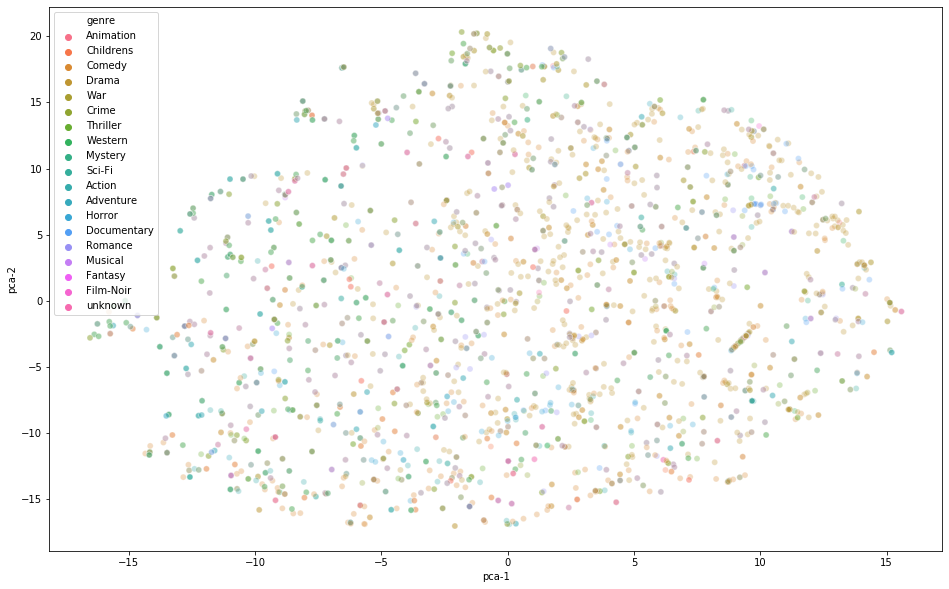

In [15]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

item_df = pd.read_pickle("data/item_df.p")
genres = ['unknown','Action' , 'Adventure', 'Animation', 'Childrens' , 'Comedy' , 'Crime', \
                                        'Documentary', 'Drama' ,'Fantasy' , 'Film-Noir' , 'Horror' , 'Musical', \
                                        'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

user_inv_idx = {} 
item_inv_idx = {} 
for k, v in transformer.u_idx.items():
    user_inv_idx[v] = k 
    
for k, v in transformer.i_idx.items():
    item_inv_idx[v] = k 

# print(item_df.head())    

vectors_to_visualize = [] 
genre_labels = [] 
for i in range(0, knn_item_matrix.shape[0]): 

    iid = item_inv_idx[i]

    for index, item_info in item_df[item_df['iid']==int(iid)].iterrows():     
        for g in genres: 
            if item_info[g] > 0:
                vectors_to_visualize.append(knn_item_matrix[i]) 
                genre_labels.append(g)
                


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
vectors_to_visualize = numpy.asarray(vectors_to_visualize)                


# pca = PCA(n_components=5)
pca = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
pca_result = pca.fit_transform(vectors_to_visualize)
d = {} 
d['pca-1'] = pca_result[:,0]
d['pca-2'] = pca_result[:,1]
d['genre'] = genre_labels

df = pd.DataFrame(data=d)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-1", y="pca-2",
    hue="genre",
    data=df,
    legend="full",
    alpha=0.3
)

In [16]:
print('KNN train features shape = ', knn_item_matrix.shape)
knn_prefix = 'knn'
knn_output_prefix  = 's3://{}/{}/output'.format(bucket, knn_prefix)
knn_train_data_path = writeDatasetToProtobuf(knn_item_matrix, bucket, knn_prefix, train_key, "dense", knn_train_label)
print('uploaded KNN train data: {}'.format(knn_train_data_path))

nb_recommendations = 100
container = get_image_uri(region, 'knn', 'latest')
crole = get_execution_role() 
instance_type='ml.m5.large'

# set up the estimator
knn = sagemaker.estimator.Estimator(container,
    crole,
    train_instance_count=1,
    train_instance_type=instance_type,
    output_path=knn_output_prefix,
    sagemaker_session=sagemaker.Session())

knn.set_hyperparameters(feature_dim=knn_item_matrix.shape[1], k=nb_recommendations, index_metric="INNER_PRODUCT", predictor_type='classifier', sample_size=200000)
fit_input = {'train': knn_train_data_path}
knn.fit(fit_input)
knn_model_name =  knn.latest_training_job.job_name
print("created model: ", knn_model_name)





'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


KNN train features shape =  (1616, 65)
uploaded KNN train data: s3://recommendation-demo-yianc/knn/train.protobuf


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-20 08:27:39 Starting - Starting the training job...
2020-08-20 08:27:41 Starting - Launching requested ML instances.........
2020-08-20 08:29:24 Starting - Preparing the instances for training...
2020-08-20 08:30:07 Downloading - Downloading input data......
2020-08-20 08:31:10 Training - Training image download completed. Training in progress.
2020-08-20 08:31:10 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[08/20/2020 08:31:03 INFO 139658739447616] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'index_metric': u'L2', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'feature_dim': u'auto', u'faiss_index_ivf_nlists': u'auto', u'epochs': u'1', u'index_type': u'faiss.Flat', u'_faiss_index_nprobe': u'5', u'_kvstore': u'dist_async', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000


2020-08-20 08:31:17 Completed - Training job completed
Training seconds: 70
Billable seconds: 70
created model:  knn-2020-08-20-08-27-39-217


In [17]:
# save the model so that we can reference it in the next step during batch inference
sm = boto3.client(service_name='sagemaker')

primary_container = {
    'Image': knn.image_name,
    'ModelDataUrl': knn.model_data,
}


knn_model = sm.create_model(
        ModelName = knn.latest_training_job.job_name,
        ExecutionRoleArn = knn.role,
        PrimaryContainer = primary_container)
print("saved the model")

saved the model


In [18]:
#upload inference data to S3
knn_batch_data_path = writeDatasetToProtobuf(knn_user_matrix, bucket, knn_prefix, train_key, "dense")
print("Batch inference data path: ",knn_batch_data_path) 

# Initialize the transformer object
knn_transformer =sagemaker.transformer.Transformer(
    base_transform_job_name="knn",
    model_name=knn_model_name,
    instance_count=1,
    instance_type=instance_type,
    output_path=knn_output_prefix,
    accept="application/jsonlines; verbose=true"
)

# Start a transform job:
knn_transformer.transform(knn_batch_data_path, content_type='application/x-recordio-protobuf')
knn_transformer.wait()


#Download predictions 
results_file_name = "inference_output"
inference_output_file = "knn/output/train.protobuf.out"
s3_client = boto3.client('s3')
s3_client.download_file(bucket, inference_output_file, results_file_name)

Batch inference data path:  s3://recommendation-demo-yianc/knn/train.protobuf
..........................Docker entrypoint called with argument(s): serve
Running default environment configuration script
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[08/20/2020 08:36:44 INFO 140679166146368] loaded entry point class algorithm.serve.server_config:config_api
[08/20/2020 08:36:44 INFO 140679166146368] loading entry points
[08/20/2020 08:36:44 INFO 140679166146368] loaded request iterator text/csv
[08/20/2020 08:36:44 INFO 140679166146368] loaded request iterator application/x-recordio-protobuf
[08/20/2020 08:36:44 INFO 140679166146368] loaded request iterator application/json
[08/20/2020 08:36:44 INFO 140679166146368] loaded request iterator application/jsonlines
[08/20/2020 08:36:44 INFO 140679166146368] loaded response encoder application/x-recordio-protobuf
[08/20/2020 08:36:44 INFO 140679166146368] loaded response encoder application/j

In [19]:
f = open(results_file_name)
rcmd_results = f.readlines()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


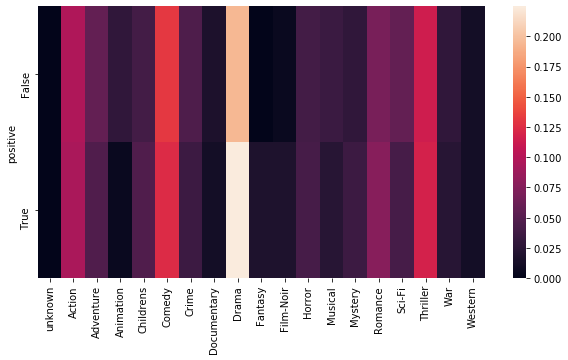

In [20]:
import json

import numpy 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


user_item_df = pd.read_pickle("data/user_item_df.p")
item_df = pd.read_pickle("data/item_df.p")
genres = ['unknown','Action' , 'Adventure', 'Animation', 'Childrens' , 'Comedy' , 'Crime', \
                                        'Documentary', 'Drama' ,'Fantasy' , 'Film-Noir' , 'Horror' , 'Musical', \
                                        'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


def plot_heat_map(df, figsize=(10,7)): 
    df = df.div(df.sum(axis=1), axis=0)     
    plt.subplots(figsize=figsize)
    sns.heatmap(df)


# test_user_idx = 89
test_user_idx = 200
u_id = user_inv_idx[test_user_idx]

tester_df = user_item_df[user_item_df['uid']==int(u_id)]
tester_df['positive'] = tester_df['rating'] >3 

review = tester_df[['positive']+genres].groupby(['positive']).sum()
plot_heat_map(review, figsize=(10,5))

In [21]:
import urllib.parse

def get_imdb_query(q):
    return 'https://www.imdb.com/find?q={}'.format(urllib.parse.quote(q))

def print_movie_title(df):
    imdb_search_url = ""
    for index, row in df.iterrows():
        print (row['title'], get_imdb_query(row['title']))


test_positive_df = user_item_df[(user_item_df['uid']==int(u_id)) & (user_item_df['rating']>3)][['title']]
print_movie_title(test_positive_df[0:10])

Ridicule (1996) https://www.imdb.com/find?q=Ridicule%20%281996%29
Net, The (1995) https://www.imdb.com/find?q=Net%2C%20The%20%281995%29
12 Angry Men (1957) https://www.imdb.com/find?q=12%20Angry%20Men%20%281957%29
Event Horizon (1997) https://www.imdb.com/find?q=Event%20Horizon%20%281997%29
Star Trek: First Contact (1996) https://www.imdb.com/find?q=Star%20Trek%3A%20First%20Contact%20%281996%29
Operation Dumbo Drop (1995) https://www.imdb.com/find?q=Operation%20Dumbo%20Drop%20%281995%29
Kansas City (1996) https://www.imdb.com/find?q=Kansas%20City%20%281996%29
Horseman on the Roof, The (Hussard sur le toit, Le) (1995) https://www.imdb.com/find?q=Horseman%20on%20the%20Roof%2C%20The%20%28Hussard%20sur%20le%20toit%2C%20Le%29%20%281995%29
Cinema Paradiso (1988) https://www.imdb.com/find?q=Cinema%20Paradiso%20%281988%29
Die Hard (1988) https://www.imdb.com/find?q=Die%20Hard%20%281988%29


In [22]:
test_negative_df = user_item_df[(user_item_df['uid']==int(u_id)) & (user_item_df['rating']<3)][['title']]
print_movie_title(test_negative_df[0:10])

Ice Storm, The (1997) https://www.imdb.com/find?q=Ice%20Storm%2C%20The%20%281997%29
Ulee's Gold (1997) https://www.imdb.com/find?q=Ulee%27s%20Gold%20%281997%29
Return of the Jedi (1983) https://www.imdb.com/find?q=Return%20of%20the%20Jedi%20%281983%29
Evil Dead II (1987) https://www.imdb.com/find?q=Evil%20Dead%20II%20%281987%29
Jurassic Park (1993) https://www.imdb.com/find?q=Jurassic%20Park%20%281993%29
Dirty Dancing (1987) https://www.imdb.com/find?q=Dirty%20Dancing%20%281987%29
Ulee's Gold (1997) https://www.imdb.com/find?q=Ulee%27s%20Gold%20%281997%29
Cold Comfort Farm (1995) https://www.imdb.com/find?q=Cold%20Comfort%20Farm%20%281995%29
River Wild, The (1994) https://www.imdb.com/find?q=River%20Wild%2C%20The%20%281994%29
Spitfire Grill, The (1996) https://www.imdb.com/find?q=Spitfire%20Grill%2C%20The%20%281996%29


In [23]:
# nns = t.get_nns_by_vector(user_vectors[str(test_user_idx)], 100, search_k=-1, include_distances=False) 
u_one_json = json.loads(rcmd_results[test_user_idx])
nns = u_one_json['labels']

for movie_id in nns[:10]:
    print_movie_title(item_df[item_df['iid']==int(movie_id)])

Feast of July (1995) https://www.imdb.com/find?q=Feast%20of%20July%20%281995%29
Demolition Man (1993) https://www.imdb.com/find?q=Demolition%20Man%20%281993%29
When Harry Met Sally... (1989) https://www.imdb.com/find?q=When%20Harry%20Met%20Sally...%20%281989%29
Phantom, The (1996) https://www.imdb.com/find?q=Phantom%2C%20The%20%281996%29
Last Summer in the Hamptons (1995) https://www.imdb.com/find?q=Last%20Summer%20in%20the%20Hamptons%20%281995%29
Highlander III: The Sorcerer (1994) https://www.imdb.com/find?q=Highlander%20III%3A%20The%20Sorcerer%20%281994%29
Mimic (1997) https://www.imdb.com/find?q=Mimic%20%281997%29
Father of the Bride Part II (1995) https://www.imdb.com/find?q=Father%20of%20the%20Bride%20Part%20II%20%281995%29
Red Firecracker, Green Firecracker (1994) https://www.imdb.com/find?q=Red%20Firecracker%2C%20Green%20Firecracker%20%281994%29
Picture Perfect (1997) https://www.imdb.com/find?q=Picture%20Perfect%20%281997%29


In [24]:
item_df = pd.read_pickle("data/item_df.p")
genres = ['unknown','Action' , 'Adventure', 'Animation', 'Childrens' , 'Comedy' , 'Crime', \
                                        'Documentary', 'Drama' ,'Fantasy' , 'Film-Noir' , 'Horror' , 'Musical', \
                                        'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

item_genres_df = item_df[['iid']+genres]


popularity = user_item_df[user_item_df['rating']>3].groupby('iid').count()['uid'].to_dict() 

user_inv_idx = {} 
item_inv_idx = {} 

for k, v in transformer.u_idx.items():
    user_inv_idx[v] = k 
    
for k, v in transformer.i_idx.items():
    item_inv_idx[v] = k 
    
def get_rcmds_of_an_user(uid):
    
    u_one_json = json.loads(rcmd_results[transformer.u_idx[uid]])
    nns = u_one_json['labels']
    results = [] 
    for iid in nns: 
        results.append(item_inv_idx[iid]) 
    return results 
    

def get_answers():
    answer = {} 
    for ui in test_user_item: 
        uid = ui[0]
        iid = ui[1]
        rating = ui[2]
        if uid not in answer:  
            answer[uid] = set() 
        if rating > 0: 
            answer[uid].add(iid)
    return answer
                

            
def similarity(genre_df1, genre_df2): 
    sim = 0 
    for i, c in enumerate(genre_df1.columns): 
        if c != 'iid':
            if genre_df1[c].iloc[0] == genre_df2[genres][c].iloc[0]: 
                sim += 1 
    return sim / len(genres) 
           
    
answer = get_answers() 


def get_metrics_related_to_recommendation(u_idx,answer, get_user_rcmd):
    '''
        1. similarity - within recommendation of a person, we calculate the similarity between two recommended items by averaging hamming distances among them 
        2. diversity - given recommendation of a person, diversity is the inverse of similarity 
        3. overall diversity - average diversity 
        4. hits - hits@10 
        5. Coverage - unique items being recommended 
        6. Novelty - inverse of popularity 
    '''
    
    all_pop = 0 
    hits = 0 
    topk = 10
    valid_user_nb = 0 
    rcmded = set()
    diversity = [] 
    
    for uid in answer.keys():
        if uid in u_idx.keys() : 
            nns = get_user_rcmd(uid)
            pred = set()
            valid_user_nb += 1 
            all_sim = []
            for i, movieid in enumerate(nns[:topk]): 
                rcmded.add(movieid)
                if int(movieid) in popularity: 
                    all_pop += popularity[int(movieid)] 
                pred.add(str(movieid))
                for j, movieid_other in enumerate(nns[:topk]):
                    if j < i:
                        movie_a_df = item_genres_df[item_genres_df['iid'] == int(movieid)]
                        movie_b_df = item_genres_df[item_genres_df['iid'] == int(movieid_other)]
                        sim = similarity(movie_a_df, movie_b_df)
                        all_sim.append(sim) 
            diversity.append(1/np.mean(np.asarray(all_sim)))             

            hits += len(pred.intersection(answer[uid]))
    print("Novelty:{}".format(1/(all_pop/topk/valid_user_nb)))
    print("Hits@10:{}".format(hits))
    print("Coverage:{}".format(len(rcmded)))
    print("Diversity:{}".format(np.mean(np.asarray(diversity))))
    
get_metrics_related_to_recommendation(transformer.u_idx,answer, get_rcmds_of_an_user)    

Novelty:0.02143138025953598
Hits@10:17
Coverage:227
Diversity:1.2174944098130422
